In [1]:
!cp -r /kaggle/input/sd-text2image/celebhq /kaggle/working/celebhq

In [2]:
!cp /kaggle/input/sd-text2image/blocks.py /kaggle/working/blocks.py

In [3]:
!pip install gdown
# to upgrade
!pip install --upgrade gdown

In [4]:
# Tạo thư mục data
!mkdir data
%cd data

!mkdir CelebAMask-HQ
%cd CelebAMask-HQ

# Tải file ảnh
!gdown 1jlQ8umhpJo8lVgC9q4_1q_t_Frv1kZ3f
!unzip image.zip

# Tải file mô tả của ảnh
!gdown 1X1EFCyralNN2Bg3LhelL_lShrSrmTitW
!unzip text.zip

# Tải file train và test
!gdown 1GdeTdBpi_IV7AuBpJAhLElqjswRmOy-7 -O train.pickle
!gdown 1JNxgdvPMI_HHUq2-JUuJp8L7cD-74OAf -O test.pickle

!mv images CelebA-HQ-img
!rm image.zip text.zip

%cd /kaggle/working/

/kaggle/working/data
/kaggle/working/data/CelebAMask-HQ
Downloading...
From (original): https://drive.google.com/uc?id=1jlQ8umhpJo8lVgC9q4_1q_t_Frv1kZ3f
From (redirected): https://drive.google.com/uc?id=1jlQ8umhpJo8lVgC9q4_1q_t_Frv1kZ3f&confirm=t&uuid=2a1d96ae-2dce-4605-91b6-b383c3f28f7c
To: /kaggle/working/data/CelebAMask-HQ/image.zip
100%|██████████████████████████████████████| 2.05G/2.05G [00:22<00:00, 90.8MB/s]
Archive:  image.zip
   creating: images/
  inflating: images/26346.jpg        
  inflating: images/18939.jpg        
  inflating: images/27155.jpg        
  inflating: images/2579.jpg         
  inflating: images/9638.jpg         
  inflating: images/20667.jpg        
  inflating: images/11561.jpg        
  inflating: images/18396.jpg        
  inflating: images/12253.jpg        
  inflating: images/27599.jpg        
  inflating: images/6199.jpg         
  inflating: images/9861.jpg         
  inflating: images/9567.jpg         
  inflating: images/25139.jpg        
  inflat

# Import thư viện cần thiết

In [5]:
!pip install einops
!pip install diffusers
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.2 MB/s eta 0:00:00


In [6]:
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
from torch.optim import Adam

from einops import einsum
from blocks import get_time_embedding
from blocks import DownBlock, MidBlock, UpBlockUnet

from diffusers import VQModel
from transformers import CLIPTokenizer, CLIPTextModel

import os
import glob
import random
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

# Dataset

In [7]:
def load_latents(latent_path):
    r"""
    Simple utility to save latents to speed up ldm training
    :param latent_path:
    :return:
    """
    latent_maps = {}
    for fname in glob.glob(os.path.join(latent_path, '*.pkl')):
        s = pickle.load(open(fname, 'rb'))
        for k, v in s.items():
            latent_maps[k] = v[0]
    return latent_maps

In [8]:
class CelebDataset(Dataset):
    r"""
    Celeb dataset will by default centre crop and resize the images.
    This can be replaced by any other dataset. As long as all the images
    are under one directory.
    """

    def __init__(self, split, im_path, im_size=256, im_channels=3, im_ext='jpg',
                 use_latents=False, latent_path=None, condition_config=None):
        self.split = split
        if self.split != 'all':
          self.split_filter = pickle.load(open(f'/kaggle/working/data/CelebAMask-HQ/{self.split}.pickle', 'rb'))

        self.im_size = im_size
        self.im_channels = im_channels
        self.im_ext = im_ext
        self.im_path = im_path
        self.latent_maps = None
        self.use_latents = False

        self.condition_types = [] if condition_config is None else condition_config['condition_types']
        self.images, self.texts = self.load_images(im_path)

        # Whether to load images or to load latents
        if use_latents and latent_path is not None:
            latent_maps = load_latents(latent_path)
            if len(latent_maps) >= len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')

    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        fnames = glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('png')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpg')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpeg')))
        texts = []

        for fname in tqdm(fnames):
            im_name = os.path.split(fname)[1].split('.')[0]

            if self.split != 'all':
              if im_name not in self.split_filter:
                continue

            ims.append(fname)

            if 'text' in self.condition_types:
                captions_im = []
                with open(os.path.join(im_path, 'celeba-caption/{}.txt'.format(im_name))) as f:
                    for line in f.readlines():
                        captions_im.append(line.strip())
                texts.append(captions_im)

        if 'text' in self.condition_types:
            assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"

        print('Found {} images'.format(len(ims)))
        print('Found {} captions'.format(len(texts)))

        return ims, texts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        ######## Set Conditioning Info ########
        cond_inputs = {}
        if 'text' in self.condition_types:
            cond_inputs['text'] = random.sample(self.texts[index], k=1)[0]
        #######################################

        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            if len(self.condition_types) == 0:
                return latent
            else:
                return latent, cond_inputs
        else:
            im = Image.open(self.images[index])
            im_tensor = torchvision.transforms.Compose([
                torchvision.transforms.Resize(self.im_size),
                torchvision.transforms.CenterCrop(self.im_size),
                torchvision.transforms.ToTensor(),
            ])(im)
            im.close()

            # Convert input to -1 to 1 range.
            im_tensor = (2 * im_tensor) - 1
            if len(self.condition_types) == 0:
                return im_tensor
            else:
                return im_tensor, cond_inputs

# Xây dựng Noise Scheduler

In [9]:
class LinearNoiseScheduler:
    """
    Linear noise scheduler được sử dụng trong DDPM
    """

    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Mimicking how compvis repo creates schedule
        # Test later
        self.betas = (
                torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2
        )


        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        """
        Hàm forward cho quá trình diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)

    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

# Mô hình UNet

In [10]:
class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """

    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.attns = model_config['attn_down']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        self.conv_out_channels = model_config['conv_out_channels']

        # Validating Unet Model configurations
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1

        ######## Class, Mask and Text Conditioning Config #####
        self.condition_config = model_config['condition_config']
        self.text_cond = True
        self.text_embed_dim = self.condition_config['text_condition_config']['text_embed_dim']
        self.cond = self.text_cond
        ###################################
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=1)

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.downs = nn.ModuleList([])

        # Build the Downblocks
        for i in range(len(self.down_channels) - 1):
            # Cross Attention and Context Dim only needed if text condition is present
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
                                        down_sample=self.down_sample[i],
                                        num_heads=self.num_heads,
                                        num_layers=self.num_down_layers,
                                        attn=self.attns[i], norm_channels=self.norm_channels,
                                        cross_attn=self.text_cond,
                                        context_dim=self.text_embed_dim))

        self.mids = nn.ModuleList([])
        # Build the Midblocks
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim,
                                      num_heads=self.num_heads,
                                      num_layers=self.num_mid_layers,
                                      norm_channels=self.norm_channels,
                                      cross_attn=self.text_cond,
                                      context_dim=self.text_embed_dim))

        self.ups = nn.ModuleList([])
        # Build the Upblocks
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(
                UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
                            self.t_emb_dim, up_sample=self.down_sample[i],
                            num_heads=self.num_heads,
                            num_layers=self.num_up_layers,
                            norm_channels=self.norm_channels,
                            cross_attn=self.text_cond,
                            context_dim=self.text_embed_dim))

        self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
        self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t, cond_input=None):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]

        # B x C x H x W -> # B x C1 x H x W
        out = self.conv_in(x)

        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        context_hidden_states = None
        context_hidden_states = cond_input['text']
        down_outs = []

        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb, context_hidden_states)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb, context_hidden_states)
        # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb, context_hidden_states)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

# Model Config

In [11]:
config = {
    "dataset_params": {
        "im_path": "data/CelebAMask-HQ",
        "im_channels": 3,
        "im_size": 256,
        "name": "celebhq"
    },
    "diffusion_params": {
        "num_timesteps": 1000,
        "beta_start": 0.00085,
        "beta_end": 0.012
    },
    "ldm_params": {
        "down_channels": [128, 256, 384, 512],
        "mid_channels": [512, 384],
        "down_sample": [True, True, True],
        "attn_down": [True, True, True],
        "time_emb_dim": 512,
        "norm_channels": 32,
        "num_heads": 16,
        "conv_out_channels": 128,
        "num_down_layers": 2,
        "num_mid_layers": 2,
        "num_up_layers": 2,
        "condition_config": {
            "condition_types": ["text"],
            "text_condition_config": {
                "text_embed_model": "clip",
                "train_text_embed_model": False,
                "text_embed_dim": 512,
                "cond_drop_prob": 0.1
            }
        }
    },
    "train_params": {
        "seed": 1111,
        "task_name": "celebhq",
        "ldm_batch_size": 1,
        "ldm_epochs": 30,
        "num_samples": 1,
        "num_grid_rows": 1,
        "ldm_lr": 0.000005,
        "save_latents": True,
        "vqvae_latent_dir_name": 'vqvae_latents',
        "cf_guidance_scale": 1.0,
        "ldm_ckpt_name": "ddpm_ckpt_text_cond_clip.pth",
    }
}


In [12]:
def get_text_representation(text, text_tokenizer, text_model, device,
                            truncation=True,
                            padding='max_length',
                            max_length=77):
    token_output = text_tokenizer(text,
                                  truncation=truncation,
                                  padding=padding,
                                  return_attention_mask=True,
                                  max_length=max_length)
    indexed_tokens = token_output['input_ids']
    att_masks = token_output['attention_mask']
    tokens_tensor = torch.tensor(indexed_tokens).to(device)
    mask_tensor = torch.tensor(att_masks).to(device)
    text_embed = text_model(tokens_tensor, attention_mask=mask_tensor).last_hidden_state
    return text_embed

In [13]:
def drop_text_condition(text_embed, im, empty_text_embed, text_drop_prob):
    if text_drop_prob > 0:
        text_drop_mask = torch.zeros((im.shape[0]), device=im.device).float().uniform_(0,
                                                                                       1) < text_drop_prob
        assert empty_text_embed is not None, ("Text Conditioning required as well as"
                                        " text dropping but empty text representation not created")
        text_embed[text_drop_mask, :, :] = empty_text_embed[0]
    return text_embed

# Trainning

In [14]:
diffusion_config = config['diffusion_params']
dataset_config = config['dataset_params']
diffusion_model_config = config['ldm_params']
train_config = config['train_params']
latents_channel = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the noise scheduler
scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                  beta_start=diffusion_config['beta_start'],
                                  beta_end=diffusion_config['beta_end'])

# Instantiate Condition related components
text_tokenizer = None
text_model = None
empty_text_embed = None
condition_config = diffusion_model_config['condition_config']
condition_types = condition_config['condition_types']

with torch.no_grad():
    # Load tokenizer and text model based on config
    text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
    text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)
    text_model.eval()

    empty_text_embed = get_text_representation([''], text_tokenizer, text_model, device)

im_dataset = CelebDataset(split='train',
                          im_path=dataset_config['im_path'],
                          im_size=dataset_config['im_size'],
                          im_channels=dataset_config['im_channels'],
                          use_latents=True,
                          latent_path=os.path.join(train_config['task_name'],
                                                   train_config['vqvae_latent_dir_name']),
                          condition_config=condition_config)

filters = list(range(0, len(im_dataset), 10))
im_dataset = torch.utils.data.Subset(im_dataset, filters)

data_loader = DataLoader(im_dataset,
                         batch_size=train_config['ldm_batch_size'],
                         shuffle=True)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 30000/30000 [00:09<00:00, 3199.98it/s]


Found 24000 images
Found 24000 captions
Found 30000 latents


In [15]:
model = Unet(im_channels=latents_channel,
             model_config=diffusion_model_config).to(device)
model.train()

num_epochs = train_config['ldm_epochs']
optimizer = Adam(model.parameters(), lr=train_config['ldm_lr'])
criterion = torch.nn.MSELoss()

In [16]:
# Run training
for epoch_idx in range(num_epochs):
    losses = []
    for data in tqdm(data_loader):
        cond_input = None
        if condition_config is not None:
            im, cond_input = data
        else:
            im = data
        optimizer.zero_grad()
        im = im.float().to(device)

        ########### Handling Conditional Input ###########
        if 'text' in condition_types:
            with torch.no_grad():
                text_condition = get_text_representation(cond_input['text'],
                                                         text_tokenizer,
                                                         text_model,
                                                         device)
                text_drop_prob = condition_config['text_condition_config']['cond_drop_prob']
                text_condition = drop_text_condition(text_condition, im, empty_text_embed, text_drop_prob)
                cond_input['text'] = text_condition
        ################################################

        # Sample random noise
        noise = torch.randn_like(im).to(device)

        # Sample timestep
        t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

        # Add noise to images according to timestep
        noisy_im = scheduler.add_noise(im, noise, t)
        noise_pred = model(noisy_im, t, cond_input=cond_input)
        loss = criterion(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print('Finished epoch:{} | Loss : {:.4f}'.format(
        epoch_idx + 1,
        np.mean(losses)))
    torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                train_config['ldm_ckpt_name']))

print('Done Training ...')

100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:1 | Loss : 0.3774


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:2 | Loss : 0.2988


100%|██████████| 2400/2400 [12:42<00:00,  3.15it/s]


Finished epoch:3 | Loss : 0.2845


100%|██████████| 2400/2400 [12:42<00:00,  3.15it/s]


Finished epoch:4 | Loss : 0.2784


100%|██████████| 2400/2400 [12:43<00:00,  3.15it/s]


Finished epoch:5 | Loss : 0.2663


100%|██████████| 2400/2400 [12:42<00:00,  3.15it/s]


Finished epoch:6 | Loss : 0.2690


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:7 | Loss : 0.2772


100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:8 | Loss : 0.2593


100%|██████████| 2400/2400 [12:45<00:00,  3.14it/s]


Finished epoch:9 | Loss : 0.2742


100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:10 | Loss : 0.2655


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:11 | Loss : 0.2618


100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:12 | Loss : 0.2529


100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:13 | Loss : 0.2547


100%|██████████| 2400/2400 [12:42<00:00,  3.15it/s]


Finished epoch:14 | Loss : 0.2618


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:15 | Loss : 0.2555


100%|██████████| 2400/2400 [12:43<00:00,  3.15it/s]


Finished epoch:16 | Loss : 0.2586


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:17 | Loss : 0.2533


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:18 | Loss : 0.2469


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:19 | Loss : 0.2494


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:20 | Loss : 0.2604


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:21 | Loss : 0.2516


100%|██████████| 2400/2400 [12:43<00:00,  3.15it/s]


Finished epoch:22 | Loss : 0.2484


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:23 | Loss : 0.2481


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:24 | Loss : 0.2508


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:25 | Loss : 0.2564


100%|██████████| 2400/2400 [12:44<00:00,  3.14it/s]


Finished epoch:26 | Loss : 0.2482


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:27 | Loss : 0.2472


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:28 | Loss : 0.2386


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:29 | Loss : 0.2468


100%|██████████| 2400/2400 [12:43<00:00,  3.14it/s]


Finished epoch:30 | Loss : 0.2437
Done Training ...


# Sample

In [17]:
model = Unet(im_channels=latents_channel,
             model_config=diffusion_model_config).to(device)
model.eval()
if os.path.exists(os.path.join(train_config['task_name'],
                               train_config['ldm_ckpt_name'])):
    print('Loaded unet checkpoint')
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  train_config['ldm_ckpt_name']),
                                     map_location=device))
else:
    raise Exception('Model checkpoint {} not found'.format(os.path.join(train_config['task_name'],
                                                          train_config['ldm_ckpt_name'])))
    
vae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
vae.eval()
vae = vae.to(device)

Loaded unet checkpoint


vqvae/config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

In [18]:
with torch.no_grad():
    xt = torch.randn((1, latents_channel, 64, 64)).to(device)
    text_prompt = ['She is a woman with blond hair. She is wearing lipstick.']
    neg_prompt = ['He is a man.']
    empty_prompt = ['']
    text_prompt_embed = get_text_representation(text_prompt,
                                                text_tokenizer,
                                                text_model,
                                                device)
    # Can replace empty prompt with negative prompt
    empty_text_embed = get_text_representation(empty_prompt, text_tokenizer, text_model, device)
    assert empty_text_embed.shape == text_prompt_embed.shape
    
    uncond_input = {
        'text': empty_text_embed
    }
    cond_input = {
        'text': text_prompt_embed
    }
    ###############################################
    
    # By default classifier free guidance is disabled
    # Change value in config or change default value here to enable it
    cf_guidance_scale = train_config['cf_guidance_scale']
    
    ################# Sampling Loop ########################
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # Get prediction of noise
        t = (torch.ones((xt.shape[0],)) * i).long().to(device)
        noise_pred_cond = model(xt, t, cond_input)
        
        if cf_guidance_scale > 1:
            noise_pred_uncond = model(xt, t, uncond_input)
            noise_pred = noise_pred_uncond + cf_guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = noise_pred_cond
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        # Save x0
        # ims = torch.clamp(xt, -1., 1.).detach().cpu()
        if i == 0:
            # Decode ONLY the final iamge to save time
            ims = vae.decode(xt).sample
        else:
            ims = x0_pred
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=1)
        img = torchvision.transforms.ToPILImage()(grid)
        
        if not os.path.exists(os.path.join(train_config['task_name'], 'cond_text_samples')):
            os.mkdir(os.path.join(train_config['task_name'], 'cond_text_samples'))
        img.save(os.path.join(train_config['task_name'], 'cond_text_samples', 'x0_{}.png'.format(i)))
        img.close()

1000it [01:41,  9.81it/s]


In [19]:
test_image = Image.open(os.path.join(train_config['task_name'], 'cond_text_samples', 'x0_{}.png'.format(0)))

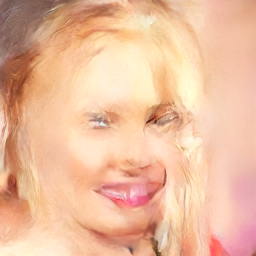

In [20]:
test_image